# Импорт библиотек и загрузка датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
# датасет вязт с https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones
ds = pd.read_csv('activity_train.csv') # Загружаем датасет
print('Размерность датасета: {}'.format(ds.shape))

Размерность датасета: (7352, 563)


In [3]:
ds.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [4]:
ds['Activity'].value_counts() # целевая переменная имеет 6 разных значений

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [5]:
x, y = ds.drop(['Activity', 'subject'], axis=1), ds['Activity'] # разделим датасет на X и y(целевой признак)
print('Размерность x: {}, размерность y: {}'.format(x.shape, y.shape))

print('Минимальное значение признака в датасете: {}, \
максимальное значение признака в датасете: {} '.format(x.min().min(), x.max().max()))

Размерность x: (7352, 561), размерность y: (7352,)
Минимальное значение признака в датасете: -1.0, максимальное значение признака в датасете: 1.0 


# Иерархическая кластеризация

In [6]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [7]:
def plot_dendrogram(model, **kwargs):
    """Создание матрицы связей и построение дендрограммы"""
    
    # создаем кол-во элементов в каждом узле
    counts = np.zeros(model.children_.shape[0]) # счетчик
    n_samples = len(model.labels_) # кол-во образцов
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # листовой узел
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float) # матрица связей

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', **kwargs)

In [8]:
agglo = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0) 
labels = agglo.fit_predict(x) # фитим модель

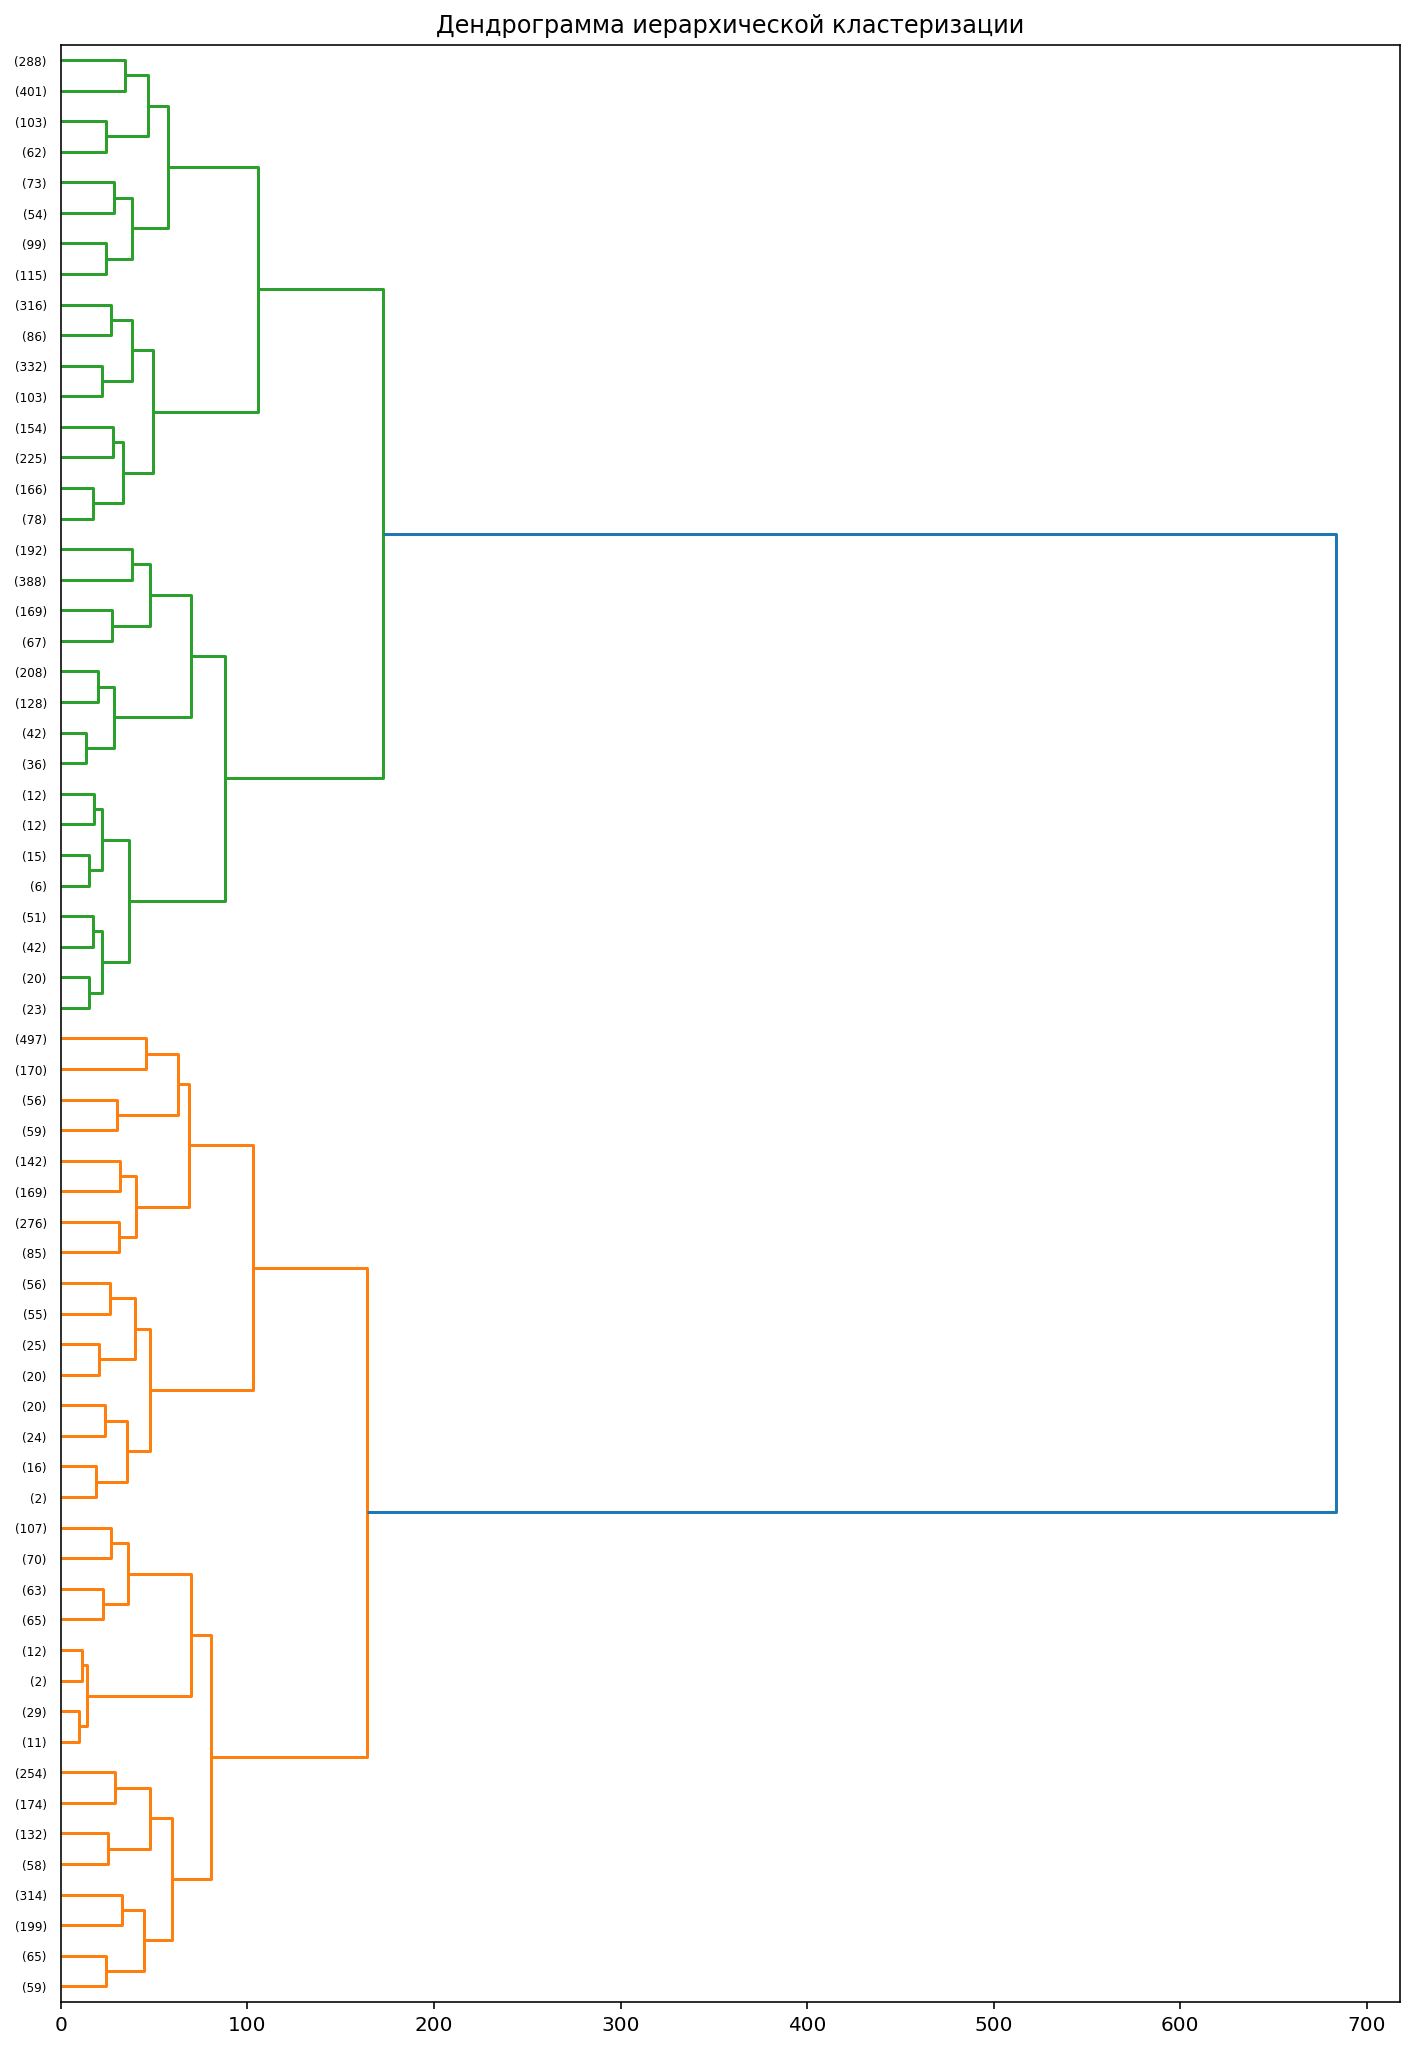

In [9]:
plt.figure(figsize=(12,18))
plot_dendrogram(agglo, truncate_mode='level', p=5)
plt.title('Дендрограмма иерархической кластеризации');

# DBSCAN

В отличие от, например, алгоритма K-Means, для DBSCAN не требуется указывать кол-во кластеров, которые мы хотим получить. Алгоритм самостоятельно выделяет кластеры, основываяся на группировке и плотности элементов.

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from itertools import product
import umap

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


Основными параметрами алгоритма являются <b>eps</b> - размер рассматриваемой окрестности вокруг точки и <b>min_samples</b> - минимальное колличество соседей, чтобы элемент можно было рассматривать как core point. Попробуем применить разные комбинации параметров для кластеризации (предварительно понизив размерность до 20 с помощью PCA) и визуализирем результаты в помощью UMAP.

In [11]:
pca = PCA(n_components=0.9, random_state=17) # инициализирем PCA преобразование c сохранением 90% дисперсии
x_reduced = pca.fit_transform(x) # трансформирует датасет

umap_transformer = umap.UMAP(n_neighbors=15, n_components=2, random_state=17) # UMAP для визуализации
x_umap = umap_transformer.fit_transform(x_reduced) # трансфомируем датасет

CPU times: user 20.4 s, sys: 7.38 s, total: 27.8 s
Wall time: 6.51 s


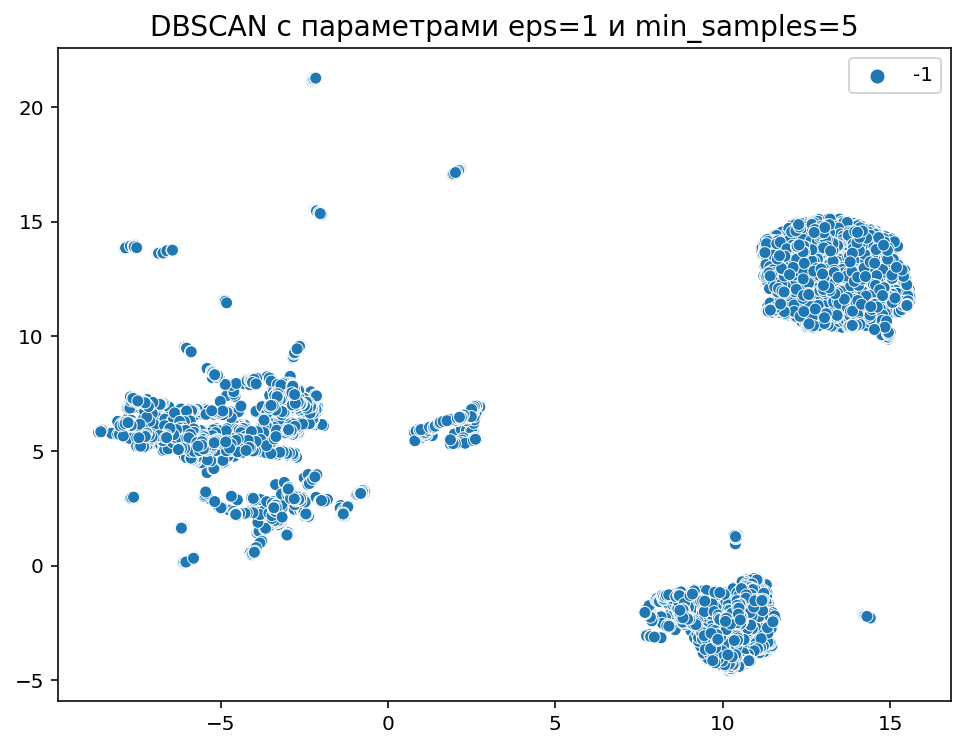

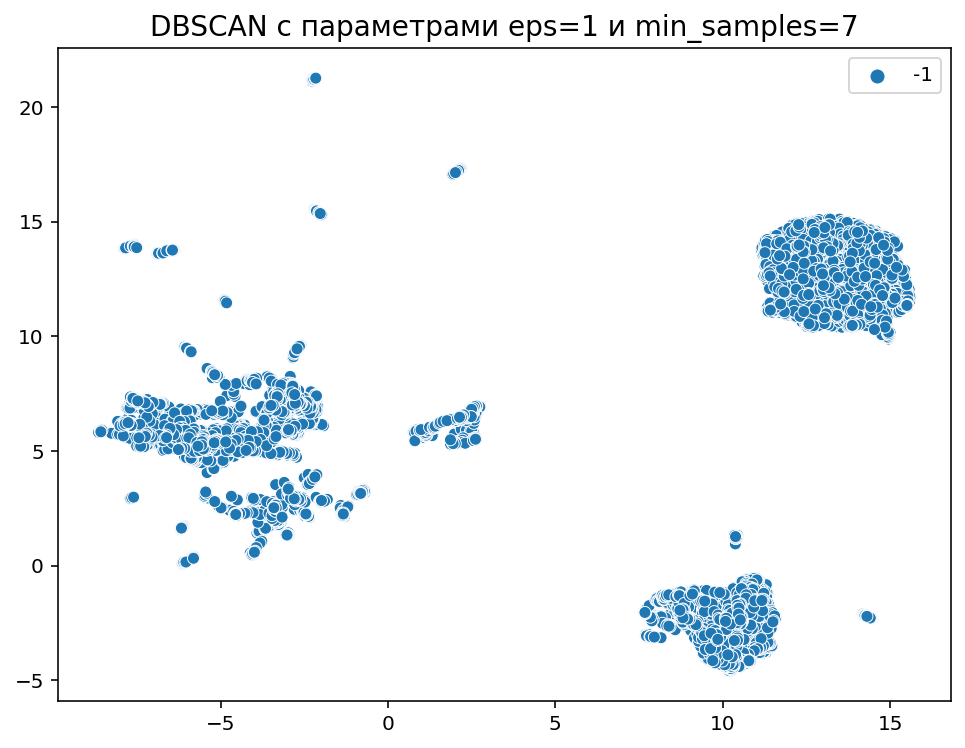

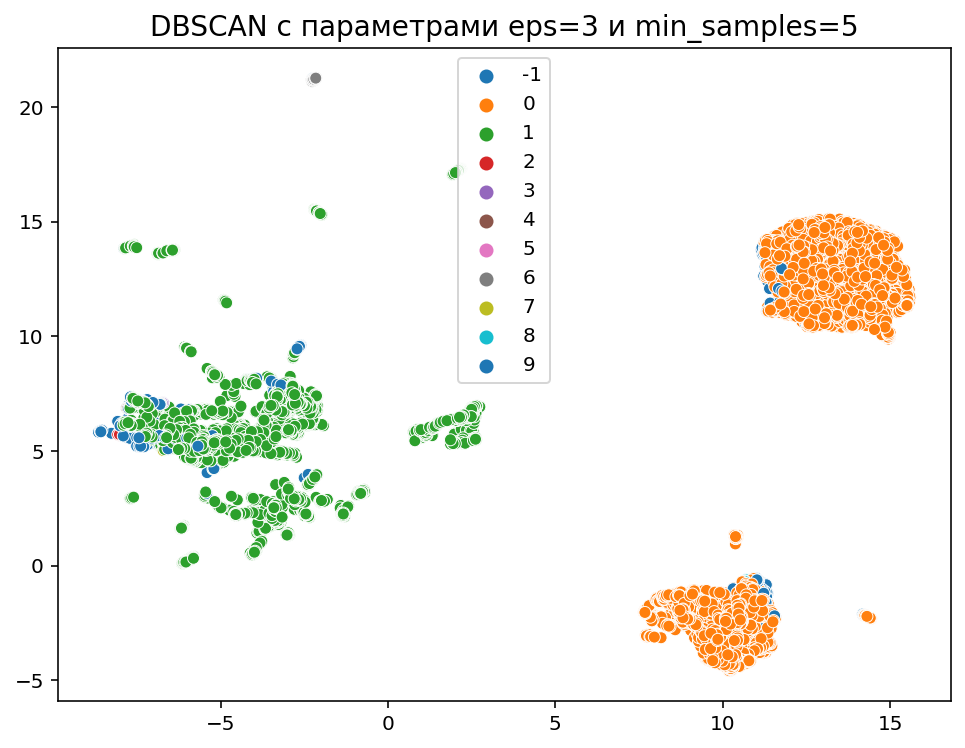

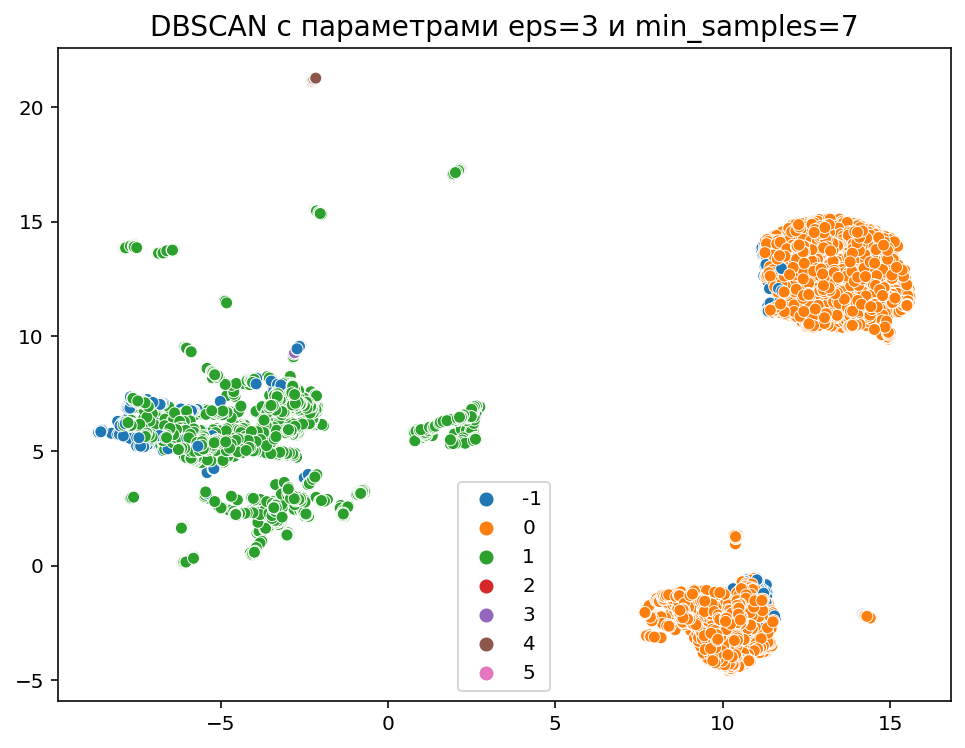

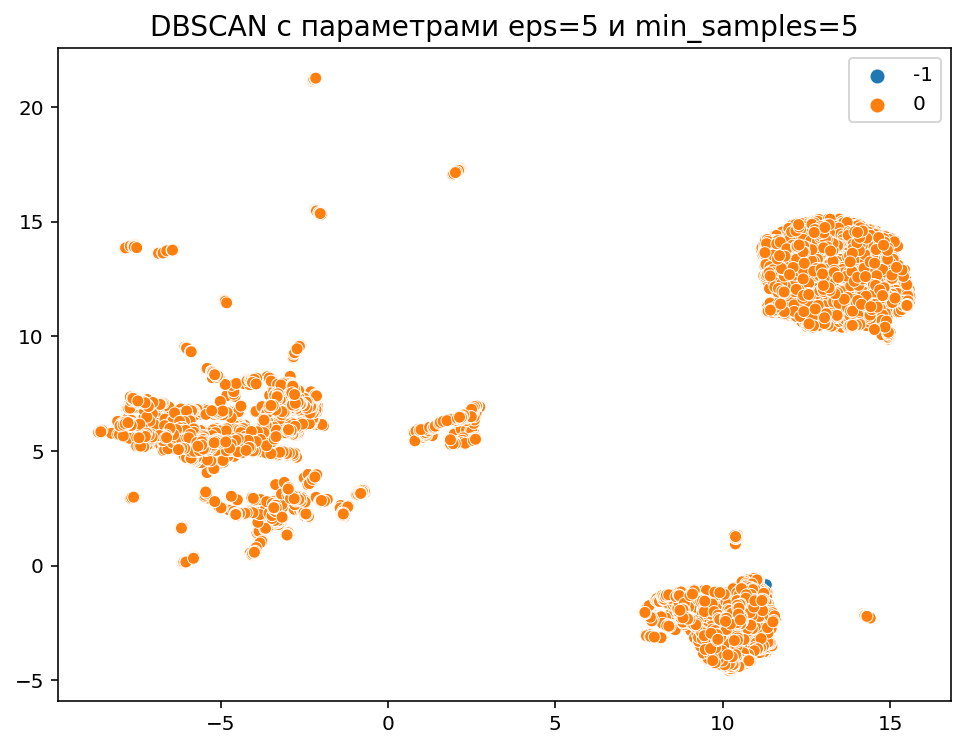

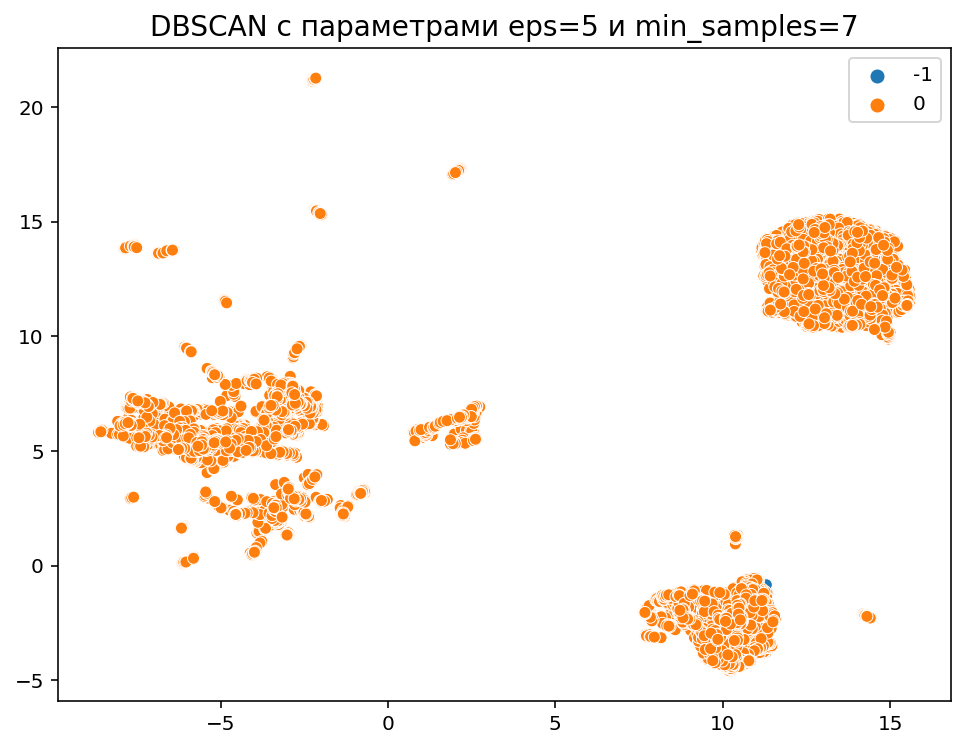

In [12]:
%%time
for eps, n in list(product((1,3,5), (5,7))):
    dbscan = DBSCAN(eps=eps, min_samples=n, n_jobs=-1) # инициализация
    labels = dbscan.fit_predict(x_reduced) # сохраняем индексы класетров
    
    # визаулизируем и окрашиваем элементы в цвета кластеров
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=x_umap[:,0], y=x_umap[:,1], hue=labels, palette='tab10').set_title(
        'DBSCAN с параметрами eps={} и min_samples={}'.format(eps, n), fontsize=14)